In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
import pandas as pd
import numpy as np
import imageio
import random


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/home/amina/ana

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/home/amina/ana

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/home/amina/ana

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/amina/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/home/amina/ana

AttributeError: _ARRAY_API not found

In [24]:
class SARSA_Agent:

    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):

        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table=np.zeros((env.observation_space.n, env.action_space.n))

        # hyper-parameters
        self.alpha = alpha                      # learning rate
        self.gamma = gamma                      # discount factor
        self.max_epsilon = max_epsilon          # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate =  decay_rate           # Exponential decay rate for exploration prob



    # get action using epsilon greedy polic
    def get_action(self, state, epsilon):
        # Randomly generate a number between 0 and 1
        random_num =random.uniform(0,1)

        # if random_num > greater than epsilon --> exploitation
        if random_num > epsilon:
           # Take the action with the highest value given a state
           # np.argmax can be useful here
           action = np.argmax(self.q_table[state])

        # else --> exploration
        else:
           action = self.env.action_space.sample()

        return action

    def update_parameters(self, state, action, reward, next_state, next_action):
        """Update Q-values using SARSA update rule"""
        # Predict current Q-value
        current_q = self.q_table[state, action]
        # Compute target using the next action
        target_q = reward + self.gamma * self.q_table[next_state, next_action]
        # Update Q-value
        new_value = current_q + self.alpha * (target_q - current_q)
        self.q_table[state, action] = new_value

    def decay_epsilon(self, episode):
        """Exponential decay for epsilon"""
        return self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)


In [34]:
def train(n_training_episodes, max_steps, env, agent):
    episode_rewards = []
    episode_penalties = []
    episode_steps = []

    for episode in tqdm(range(n_training_episodes)):
        total_rewards_ep = 0
        total_penalties_ep = 0
        total_steps_ep = 0

        # Decay epsilon
        epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate * episode)

        # Reset environment
        state, info = env.reset()
        action = agent.get_action(state, epsilon)

        terminated = False
        truncated = False

        while not (terminated or truncated):
            # Take the chosen action
            next_state, reward, terminated, truncated, info = env.step(action)

            # Choose next action (on-policy)
            next_action = agent.get_action(next_state, epsilon)

            # Update Q-values
            agent.update_parameters(state, action, reward, next_state, next_action)

            # Track episode metrics
            total_rewards_ep += reward
            total_steps_ep += 1
            if reward == -10:
                total_penalties_ep += 1

            # Move to next state and action
            state, action = next_state, next_action

        episode_rewards.append(total_rewards_ep)
        episode_steps.append(total_steps_ep)
        episode_penalties.append(total_penalties_ep)

    return episode_rewards, episode_steps, episode_penalties

In [35]:
# Training parameters
n_training_episodes = 1000  # Total training episodes
alpha= 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [36]:
#env=gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
env=gym.make("Taxi-v3", render_mode="rgb_array")

agent=SARSA_Agent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards,episode_steps, episode_penalties=train(n_training_episodes, max_steps, env,agent)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 127.21it/s]


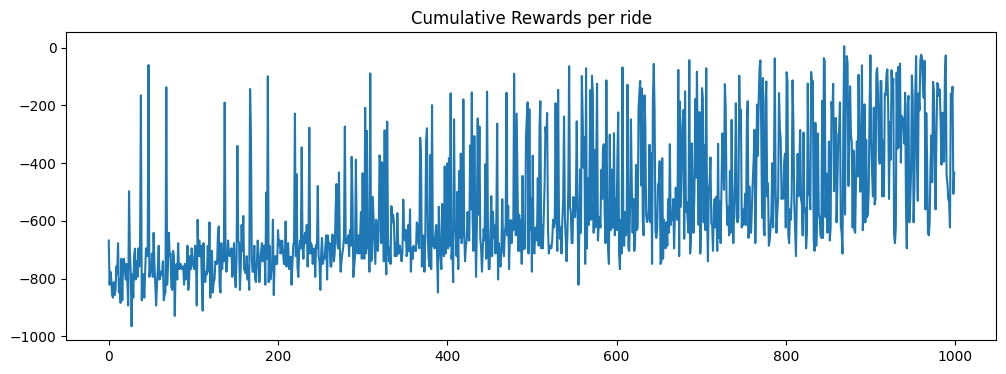

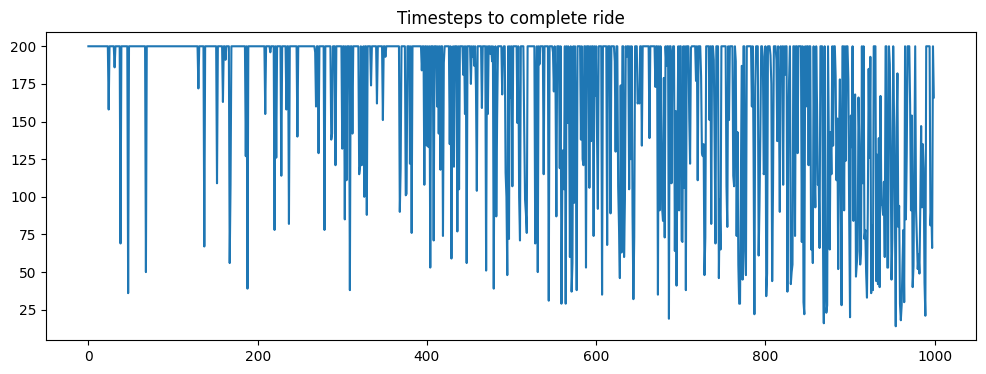

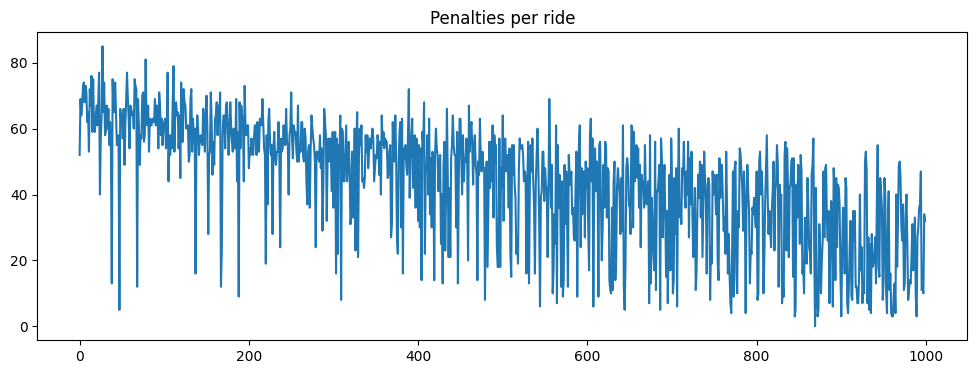

In [37]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Evaluate the QAgent after training

In [38]:
def evaluate_agent(env,agent,  n_eval_episodes):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param agent: the gent within its  evaluation environment and Qtable
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
   """
  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_eval_episodes)):

    state, info= env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0
    done= False

    while not done:
      # Take the action (index) that have the maximum expected future reward given that state
      # we use epsilon=0 for exploitation

      action = agent.get_action(state,0)
      next_state, reward, terminated, truncated, info = env.step(action)

      total_rewards_ep += reward
      total_steps_ep+=1

      if reward == -10:
            total_penalties_ep += 1

      done=terminated or truncated

      if done:
        break

      state = next_state

    episode_rewards.append(total_rewards_ep)
    episode_steps.append(total_steps_ep)
    episode_penalties.append(total_penalties_ep)

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, episode_rewards,episode_steps, episode_penalties

In [39]:
mean_reward, std_reward,episode_rewards,episode_steps, episode_penalties=evaluate_agent(env,agent, 1000)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

100%|██████████| 1000/1000 [00:06<00:00, 150.23it/s]

Mean_reward=-197.86 +/- 21.27


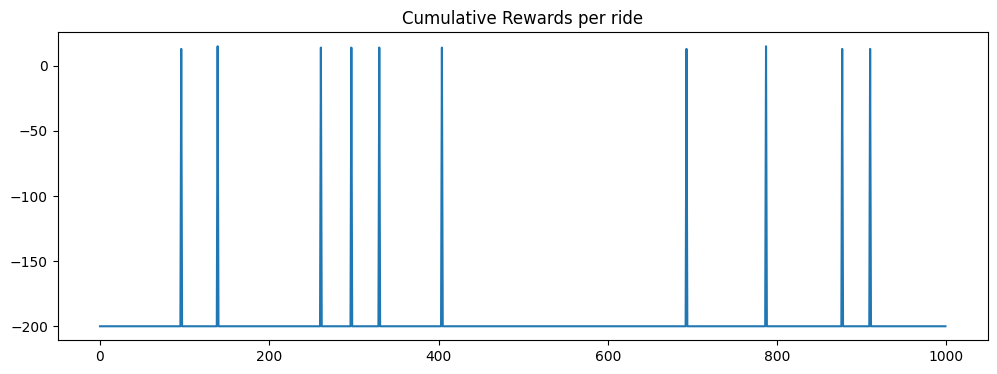

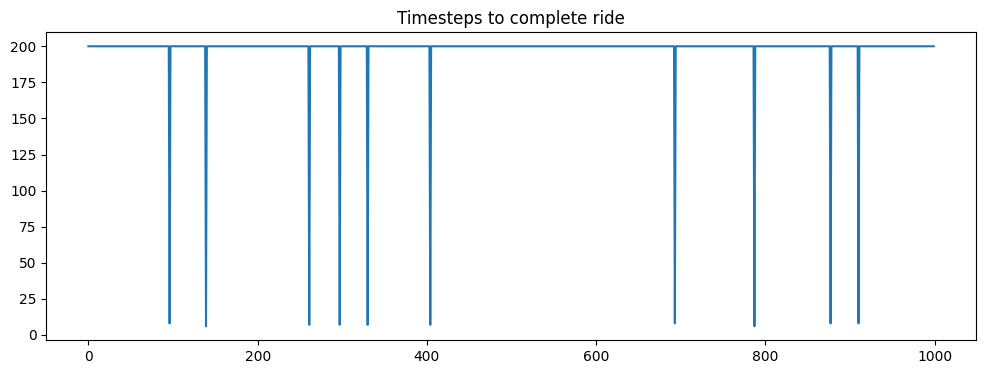

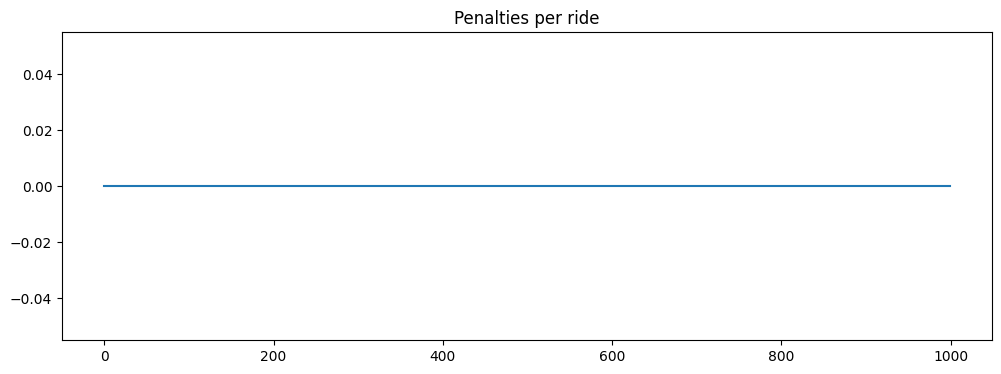

In [40]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Record a simulation as a video

In [41]:
def record_video(env, agent, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param agent:  agent within its Qtable
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(agent.q_table[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:

from base64 import b64encode
from IPython.display import HTML

# generate the video
video_path = "./replay.mp4"
record_video(env, agent, video_path, 1)

# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls>      <source src="%s" type="video/mp4"></video>""" % data_url)